In [17]:
indir <- "/data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Flt3l/outs/filtered_peak_bc_matrix/"
frag_gz <- "/data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Flt3l/outs/fragments.tsv.gz"
indir_mgatk <- "/data2/mito_lineage/data/processed/mttrace/CHIP_april08_2021/MTblacklist/Flt3l/MT/cellr_True/Flt3l_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/"
name <- "Flt3l"
outdir <- "/data2/mito_lineage/Analysis/annotation/output/data/"
prefix <- "CHIP_april08_2021_Croker/MTblacklist/"
external_dat_file <- "granja_published_C1.rds"
external_dat_dir <- "/data2/mito_lineage/Analysis/annotation/data/granja_cd34"
nTop = 25000

In [ ]:
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)

In [18]:
set.seed(1234)


In [19]:
genedir <- outdir
outdir <- file.path(outdir, prefix)
outdir

[1] "/data2/mito_lineage/Analysis/annotation/output/data//CHIP_april08_2021_Croker/MTblacklist/"

In [ ]:
library(Signac)

In [4]:
source("/data2/mito_lineage/R_scripts/annotations/01_CD34_projection.R")

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, ro

In [5]:
# library(Matrix)
# library(SummarizedExperiment)
# library(tidyverse)
# library(umap)
# library(edgeR)
# library(FNN)
# library(matrixStats)
# library(igraph)
# library(BuenColors)
# library(GenomicRanges)
# set.seed(1)
# "%ni%" <- Negate("%in%")

## Import granja data

In [6]:
library(data.table)


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


The following object is masked from ‘package:SummarizedExperiment’:

    shift


The following object is masked from ‘package:GenomicRanges’:

    shift


The following object is masked from ‘package:IRanges’:

    shift


The following objects are masked from ‘package:S4Vectors’:

    first, second




In [7]:
if(TRUE){
  granja_mat <- fread(file.path(external_dat_dir, "GSE129785_scATAC-Hematopoiesis-CD34.mtx.gz"), skip = 2)
  sm <- sparseMatrix(i = granja_mat[["V1"]], j = granja_mat[["V2"]], x = granja_mat[["V3"]])
  colData <- fread(file.path(external_dat_dir, "GSE129785_scATAC-Hematopoiesis-CD34.cell_barcodes.txt")) %>% data.frame()
  peaks <- fread(file.path(external_dat_dir, "GSE129785_scATAC-Hematopoiesis-CD34.peaks.bed")) %>%
    data.frame() %>% setnames(c('chr', 'start', 'end')) %>% makeGRangesFromDataFrame()
  SEall <- SummarizedExperiment(
    rowData = peaks,
    colData = colData, 
    assays = list(counts = sm)
  )
  CD34boo <- colData$Group %in% c("CD34_Progenitors_Rep1","CD34_Progenitors_Rep2")
  c1boo <-  colData$Group %in% c("BM_pDC", "CLP", "CMP", "GMP", "HSC", "LMPP", "MEP", "Monocytes", "MPP")
  SE_CD34 <- SEall[,CD34boo]
  SE_C1 <- SEall[,c1boo]
  saveRDS(SE_C1, file = file.path(outdir, "granja_published_C1.rds"))
  saveRDS(SE_CD34, file.path(outdir, "granja_10X_CD34.rds"))
  
}



In [21]:
genebodyandpromoter.coords <- readRDS(file.path(genedir, "genebodyandpromoter.coords_EnsDb.Hsapiens.v75.rds"))


In [38]:
Annotation(SE_CD34)

ERROR: Error in UseMethod(generic = "Annotation", object = object): no applicable method for 'Annotation' applied to an object of class "c('RangedSummarizedExperiment', 'SummarizedExperiment', 'RectangularData', 'Vector', 'Annotated', 'vector_OR_Vector')"


In [39]:
Annotation(SE_CD34)

ERROR: Error in UseMethod(generic = "Annotation", object = object): no applicable method for 'Annotation' applied to an object of class "c('RangedSummarizedExperiment', 'SummarizedExperiment', 'RectangularData', 'Vector', 'Annotated', 'vector_OR_Vector')"


In [ ]:
CD34.gene.activities <- FeatureMatrix(
    fragments = fragments,
    features = genebodyandpromoter.coords,
    cells = cells,
    process_n = 32)
CD34.gene.activities

In [6]:
import_se <- function(indir, library){
  print(file.path(indir, paste0(library,".rds")))
  se <- readRDS(file.path(indir, paste0(library,".rds")))
  colnames(se) <- paste0(library, "_", colnames(se))
  se
}


SE <- cbind(
  import_se(outdir, "Flt3l")
)



[1] "/data2/mito_lineage/Analysis/annotation/output/data//CHIP_april08_2021_Croker/MTblacklist//Flt3l.rds"


# Run the workflow

## 1. Run LSI 1st Iteration

In [9]:
lsi1 <- calcLSI(assay(SE), nComponents = 25, binarize = TRUE, nFeatures = NULL)
clust1 <- louvainIgraphClusters(lsi1[[1]], 10)


Binarizing matrix...

Computing Term Frequency IDF...

Computing SVD using irlba...



## 2. Make Pseudo Bulk Library


In [10]:
message("Making PseudoBulk...")
clusterSums <- groupSums(mat = assay(SE), groups = clust1, sparse = TRUE) #Group Sums
logMat <- edgeR::cpm(clusterSums, log = TRUE, prior.count = 3) #log CPM matrix
varPeaks <- head(order(matrixStats::rowVars(logMat), decreasing = TRUE), nTop) #Top variable peaks


Making PseudoBulk...



## 3. Run LSI 2nd Iteration

In [11]:
lsi2 <- calcLSI(assay(SE)[varPeaks,,drop=FALSE], nComponents = 25, binarize = TRUE, nFeatures = NULL)
clust2 <- louvainIgraphClusters(lsi2[[1]][,c(2:25)], 30)
length(unique(clust2))


Binarizing matrix...

Computing Term Frequency IDF...

Computing SVD using irlba...



[1] 7

### build mean for clusters

In [ ]:
means_lsi <- build_means_for_clusters(lsi2$matSVD, clust2)
lsiPeaks <- varPeaks
lsiReference <- lsi2


## Run UMAP on 2nd LSI

In [12]:
set.seed(1)
umap <- umap::umap(
  lsi2$matSVD[,2:25], 
  n_neighbors = 55, # original 55
  min_dist = 0.45, # original 0.45
  metric = "cosine", 
  verbose = TRUE    )
set.seed(10)

[2021-07-09 00:36:59]  starting umap

[2021-07-09 00:36:59]  creating graph of nearest neighbors

[2021-07-09 00:37:54]  creating initial embedding

[2021-07-09 00:37:56]  optimizing embedding

[2021-07-09 00:38:10]  done



In [ ]:
umap_clust2 <- louvainIgraphClusters(umap$layout, k = 100)
length(unique(umap_clust2))
umap_means_lsi <- build_means_for_clusters(umap$layout, umap_clust2)

In [13]:
umap

umap embedding of 4073 items in 2 dimensions
object components: layout, data, knn, config



## Project external data to our space

In [17]:
file.path(external_dat_dir, external_dat_file)


[1] "/data2/mito_lineage/Analysis/annotation/data/granja_CD34/granja_published_C1.rds"

In [19]:
sel <- readRDS(file.path(external_dat_dir, external_dat_file))
sel

class: RangedSummarizedExperiment 
dim: 571389 2196 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(0):
colnames: NULL
colData names(9): UMAP1 UMAP2 ... Internal_Name Group_Barcode

In [23]:
unique(colData(sel)$Internal_Name)

[1] "CD14_monocytes_29"   "CD14_monocytes_99"   "CD14_monocytes_203" 
   [4] "CD14_monocytes_372"  "CD14_monocytes_350"  "CD14_monocytes_320" 
   [7] "CD14_monocytes_1009" "CD14_monocytes_1010" "CD14_monocytes_282" 
  [10] "CD14_monocytes_39"   "CD14_monocytes_329"  "CD14_monocytes_695" 
  [13] "CD14_monocytes_671"  "CD14_monocytes_619"  "CD14_monocytes_342" 
  [16] "CD14_monocytes_1222" "CD14_monocytes_1224" "CD14_monocytes_640" 
  [19] "CD14_monocytes_1232" "CD14_monocytes_1091" "CD14_monocytes_762" 
  [22] "CD14_monocytes_759"  "CD14_monocytes_1254" "CD14_monocytes_338" 
  [25] "CD14_monocytes_1260" "CD14_monocytes_538"  "CD14_monocytes_143" 
  [28] "CD14_monocytes_1302" "CD14_monocytes_1304" "CD14_monocytes_1309"
  [31] "CD14_monocytes_1310" "CD14_monocytes_161"  "CD14_monocytes_335" 
  [34] "CD14_monocytes_1312" "CD14_monocytes_1314" "CD14_monocytes_1316"
  [37] "CD14_monocytes_1317" "CD14_monocytes_166"  "CD14_monocytes_579" 
  [40] "CD14_monocytes_1307" "CD14_monocytes_1320" "CD14_monocytes_120" 
  [43] "CD14_monocytes_558"  "CD14_monocytes_761"  "CD14_monocytes_806" 
  [46] "CD14_monocytes_1160" "CD14_monocytes_1367" "CD14_monocytes_1327"
  [49] "CD14_monocytes_396"  "CD14_monocytes_1374" "CD14_monocytes_1380"
  [52] "CD14_monocytes_1384" "CD14_monocytes_549"  "CD14_monocytes_1210"
  [55] "CD14_monocytes_1386" "CD14_monocytes_117"  "CD14_monocytes_530" 
  [58] "CD14_monocytes_824"  "CD14_monocytes_775"  "CD14_monocytes_264" 
  [61] "CD14_monocytes_900"  "CD14_monocytes_1392" "CD14_monocytes_711" 
  [64] "CD14_monocytes_365"  "CD14_monocytes_1408" "CD14_monocytes_1405"
  [67] "CD14_monocytes_476"  "CD14_monocytes_205"  "CD14_monocytes_1413"
  [70] "CD14_monocytes_1415" "CD14_monocytes_1300" "CD14_monocytes_149" 
  [73] "CD14_monocytes_325"  "CD14_monocytes_1097" "CD14_monocytes_1433"
  [76] "CD14_monocytes_1434" "CD14_monocytes_1428" "CD14_monocytes_440" 
  [79] "CD14_monocytes_1448" "CD14_monocytes_1449" "CD14_monocytes_279" 
  [82] "CD14_monocytes_610"  "CD14_monocytes_1473" "CD14_monocytes_551" 
  [85] "CD14_monocytes_340"  "CD14_monocytes_1478" "CD14_monocytes_1529"
  [88] "CD14_monocytes_1551" "CD14_monocytes_1555" "CD14_monocytes_252" 
  [91] "CD14_monocytes_286"  "CD14_monocytes_439"  "CD14_monocytes_1601"
  [94] "CD14_monocytes_1590" "CD14_monocytes_1604" "CD14_monocytes_1606"
  [97] "CD14_monocytes_1496" "CD14_monocytes_1629" "CD14_monocytes_456" 
 [100] "CD14_monocytes_193"  "CD14_monocytes_1514" "CD14_monocytes_1505"
 [103] "CD14_monocytes_1721" "CD14_monocytes_666"  "CD14_monocytes_1141"
 [106] "CD14_monocytes_492"  "CD14_monocytes_1229" "CD14_monocytes_295" 
 [109] "CD14_monocytes_1422" "CD14_monocytes_116"  "CD14_monocytes_1759"
 [112] "CD14_monocytes_176"  "CD14_monocytes_460"  "CD14_monocytes_471" 
 [115] "CD14_monocytes_1617" "CD14_monocytes_595"  "CD14_monocytes_1838"
 [118] "CD14_monocytes_1771" "CD14_monocytes_371"  "CD14_monocytes_1827"
 [121] "CD14_monocytes_1787" "CD14_monocytes_1789" "CLP_3"              
 [124] "CLP_2"               "CLP_12"              "CLP_4"              
 [127] "CLP_44"              "CLP_94"              "CLP_84"             
 [130] "CLP_127"             "CLP_39"              "CLP_152"            
 [133] "CLP_109"             "CLP_90"              "CLP_71"             
 [136] "CLP_57"              "CLP_69"              "CLP_96"             
 [139] "CLP_107"             "CLP_97"              "CLP_92"             
 [142] "CLP_31"              "CLP_73"              "CLP_79"             
 [145] "CLP_95"              "CLP_85"              "CLP_100"            
 [148] "CLP_11"              "CLP_7"               "CLP_118"            
 [151] "CLP_81"              "CLP_5"               "CLP_30"             
 [154] "CLP_42"              "CLP_115"             "CLP_98"             
 [157] "CLP_124"             "CLP_80"              "CLP_38"             
 [160] "CLP_55"              "CLP_131"             "CLP_105"            
 [163] "CLP_8"               "CLP_28"              "CLP_87"  

In [24]:
lsiProjection <- projectLSI((assay(sel)[varPeaks,]), lsi2)
umapProjection <- round(predict(umap, data.matrix(lsiProjection[,2:25])), 2)


dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

Binarizing matrix...

Computing Term Frequency IDF...

Computing SVD using irlba...

[2021-07-09 00:41:06]  creating graph of nearest neighbors

[2021-07-09 00:42:18]  creating initial embedding

[2021-07-09 00:42:18]  optimizing embedding

[2021-07-09 00:42:20]  done



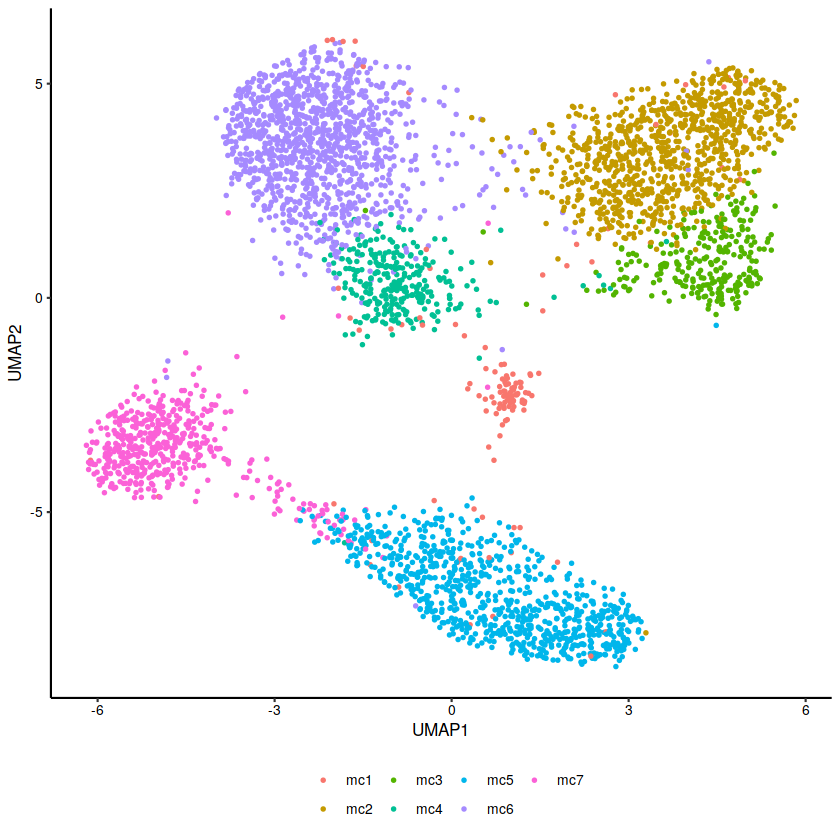

In [25]:
# Multiply by -1 to make the pseudotime read left to right
plot_df <- data.frame(umap$layout*-1, colData(SE), Clusters = clust2)

p0 <- ggplot(plot_df, aes(x= X1, y = X2, color = Clusters)) +
   geom_point(size = 0.5) +
   labs(x = "UMAP1", y= "UMAP2", color = "") +
  pretty_plot() + L_border() + theme(legend.position = "bottom")

print(p0)

In [27]:
projection_df <- data.frame(
  celltype = c(gsub("BM_", "", colData(sel)$Group), rep("none", dim(plot_df)[1])),
  umap1 = c(umapProjection[,1]*-1, plot_df$X1),
  umap2 = c(umapProjection[,2]*-1, plot_df$X2)
)
projection_df

celltype,umap1,umap2
<chr>,<dbl>,<dbl>
Monocytes,4.21,0.37
Monocytes,4.64,1.23
Monocytes,-1.25,-0.94
Monocytes,3.18,0.43
Monocytes,4.07,0.11
Monocytes,2.46,0.09
Monocytes,3.20,0.04
Monocytes,3.63,0.59
Monocytes,2.75,0.26


In [28]:
projection_df[dim(projection_df)[1]:1,]

,celltype,umap1,umap2
,<chr>,<dbl>,<dbl>
6269,none,-4.73119926,-3.09253008
6268,none,3.50870839,3.86445033
6267,none,-4.83896736,-2.85045048
6266,none,-2.95770561,5.10876763
6265,none,-2.69094723,-4.69860937
6264,none,0.01313924,-5.65674676
6263,none,4.68206016,3.87688431
6262,none,0.82771554,-6.36000447
6261,none,1.17126975,-8.23618465


In [29]:
unique(projection_df$celltype)

[1] "Monocytes" "CLP"       "CMP"       "GMP"       "HSC"       "LMPP"     
 [7] "pDC"       "MEP"       "MPP"       "none"

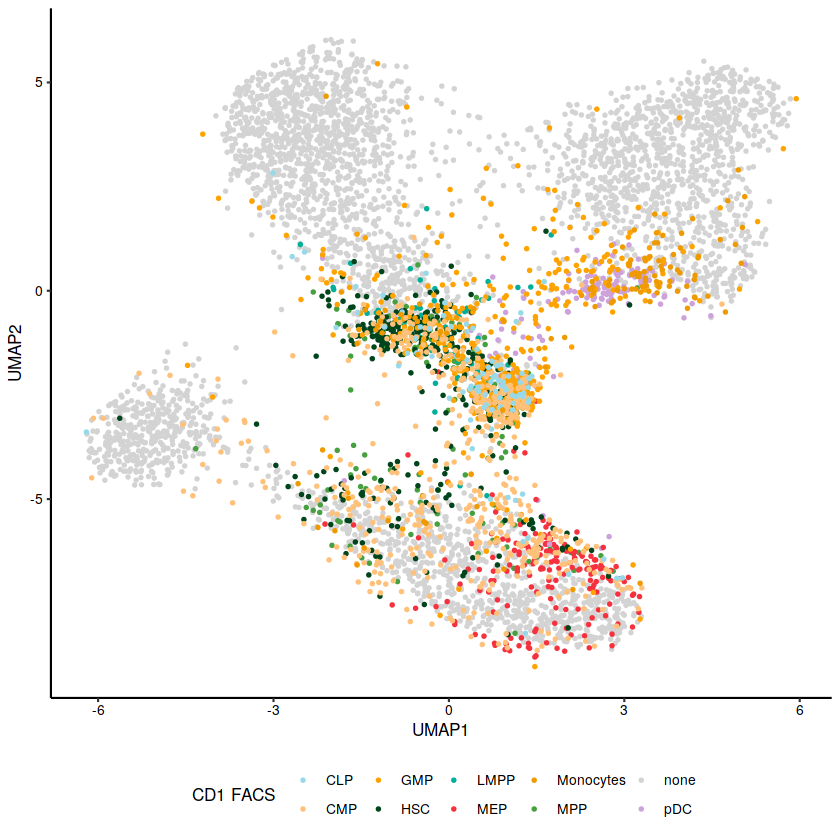

In [30]:
p1 <- ggplot(projection_df[dim(projection_df)[1]:1,], aes(x= umap1, y = umap2, color = celltype, label = celltype)) +
  geom_point(size = 0.5) +
  labs(x = "UMAP1", y= "UMAP2", color = "CD1 FACS ") +
  pretty_plot() + L_border() + theme(legend.position = "bottom") +
  scale_color_manual(values = c(ejc_color_maps, "none" = "lightgrey", "Monocytes" = "orange2"))
print(p1)



## LSI Project and classify 
(Also try the umap project and classify

In [ ]:
projected_clustersbasic <- classify_from_reference(t(means_lsi)[,1:25],data.matrix(lsiProjection)[,1:25])
projected_clusters <- annovec[as.character(projected_clustersbasic)]


In [ ]:
umap_projected_clustersbasic <- classify_from_reference(t(means_umap),data.matrix(umapProjection))
umap_projected_clusters <- annovec[as.character(umap_projected_clustersbasic)]

In [ ]:
  #UMAP Projection
  #Set Seed Prior to umap_transform (see uwot github)
  set.seed(1)
  umapProjection <- round(predict(umap, data.matrix(lsiProjection[,1:25])), 2)
  odf <- data.frame(barcode = rownames(umapProjection), umapProjection, cluster = projected_clusters)
  names(odf) <- c("barcode", "umap1", "umap2", "cluster")

  write.table(odf, paste0("../output/projection_dfs/", exp, "_projection.tsv"), 
              sep = "\t", quote = FALSE, row.names = FALSE, col.names = TRUE)

## Save

In [ ]:
save(projection_df, plot_df, file = file.path(outdir,"CD1_umap_embedding_granja.rda"))